In [1]:
import torch

In [3]:
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/media/reza/ResearchDrive/Courses/Course_PyTorch/PYTORCH_NOTEBOOKS/Data/NYCTaxiFares.csv')

In [6]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [7]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [8]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d


In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [10]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [17]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [18]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [19]:
cat_cols = ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [20]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [21]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [22]:
df.dtypes


pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [23]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

In [24]:
cats = torch.tensor(cats, dtype=torch.int64) 

In [25]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

In [26]:
y = torch.tensor(df[y_col].values, dtype=torch.float)

In [27]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [28]:
y.shape

torch.Size([120000, 1])

In [29]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [43]:
catz = cats[:1]

In [44]:
catz

tensor([[4, 0, 1]])

In [36]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for (ni,nf) in emb_szs])

In [39]:
selfembeds
    

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [45]:
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [46]:
embeddingz

[tensor([[-0.8344,  1.9094,  0.5292,  0.4465, -0.7509, -1.0912,  0.3809,  0.4416,
          -0.5249, -1.3744,  2.0084, -0.8766]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.6417]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.5663, -0.2375,  0.0783, -0.0740]], grad_fn=<EmbeddingBackward>)]

In [56]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):
        
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for (ni,nf) in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum(nf for ni,nf in emb_szs)
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)

    
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        
        return x



In [58]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [60]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [61]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [62]:
import time
start_time = time.time()
epochs = 300
losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i%10 ==1:
        print(f'epoch: {i} loss is {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time()-start_time
print(f'training took {duration/60} minutes')

    

epoch: 1 loss is 12.499530792236328
epoch: 11 loss is 12.168286323547363
epoch: 21 loss is 11.743607521057129
epoch: 31 loss is 11.315595626831055
epoch: 41 loss is 10.892244338989258
epoch: 51 loss is 10.471625328063965
epoch: 61 loss is 10.075385093688965
epoch: 71 loss is 9.70362663269043
epoch: 81 loss is 9.366241455078125
epoch: 91 loss is 9.050932884216309
epoch: 101 loss is 8.7283935546875
epoch: 111 loss is 8.386552810668945
epoch: 121 loss is 8.009098052978516
epoch: 131 loss is 7.605659008026123
epoch: 141 loss is 7.175416469573975
epoch: 151 loss is 6.707758903503418
epoch: 161 loss is 6.224124431610107
epoch: 171 loss is 5.7324538230896
epoch: 181 loss is 5.254539489746094
epoch: 191 loss is 4.784412384033203
epoch: 201 loss is 4.370254993438721
epoch: 211 loss is 4.0154128074646
epoch: 221 loss is 3.7720589637756348
epoch: 231 loss is 3.630375623703003
epoch: 241 loss is 3.5597286224365234
epoch: 251 loss is 3.5166702270507812
epoch: 261 loss is 3.4808974266052246
epoch: 2

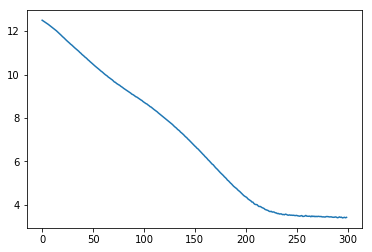

In [63]:
plt.plot(np.arange(epochs),losses)

In [64]:
with torch.no_grad():
    y_val = model(cat_test,con_test)
    loss = torch.sqrt(criterion(y_val,y_test))

In [65]:
loss

tensor(3.3460)

In [66]:
y_val

tensor([[ 2.4752],
        [25.1666],
        [ 6.3780],
        ...,
        [ 4.6792],
        [ 8.4271],
        [25.2276]])

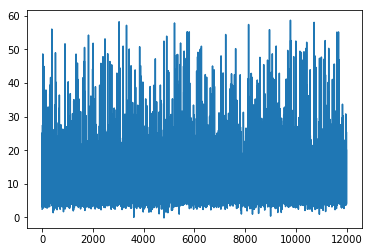

In [71]:

plt.plot(np.arange(y_val.shape[0]),y_val.numpy())

In [69]:
y_val.shape[0]

12000